# Step Matrix basic example

In [2]:
import retentioneering

# load sample data
data = retentioneering.datasets.load_simple_shop()

retentioneering.config.update({
    'event_col':'event',
    'event_time_col':'timestamp',
    'index_col': 'user_id'
})

In [3]:
single_user = data[data['user_id']==613604495].reset_index(drop=True)
single_user

,client_id,event,timestamp
0,613604495,main,2019-11-02 23:25:03.672939
1,613604495,catalog,2019-11-02 23:25:07.390498
2,613604495,catalog,2019-11-02 23:25:48.043605
3,613604495,product2,2019-11-02 23:26:08.845033
4,613604495,cart,2019-11-02 23:26:37.007346
5,613604495,catalog,2019-11-02 23:26:38.406224
6,613604495,cart,2019-11-02 23:27:09.279245
7,613604495,catalog,2019-11-02 23:27:11.432713
8,613604495,product2,2019-11-02 23:27:43.193619
9,613604495,cart,2019-11-02 23:27:48.110186


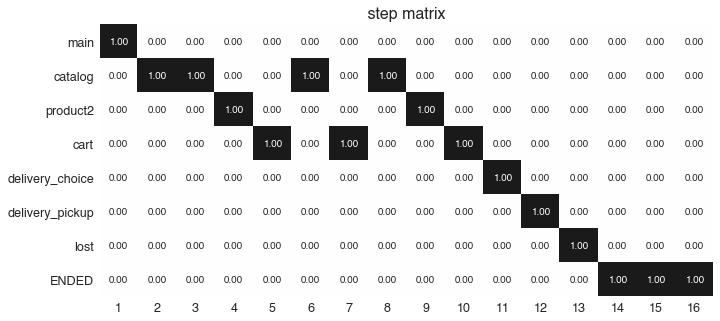

In [4]:
single_user.rete.step_matrix(max_steps=16);

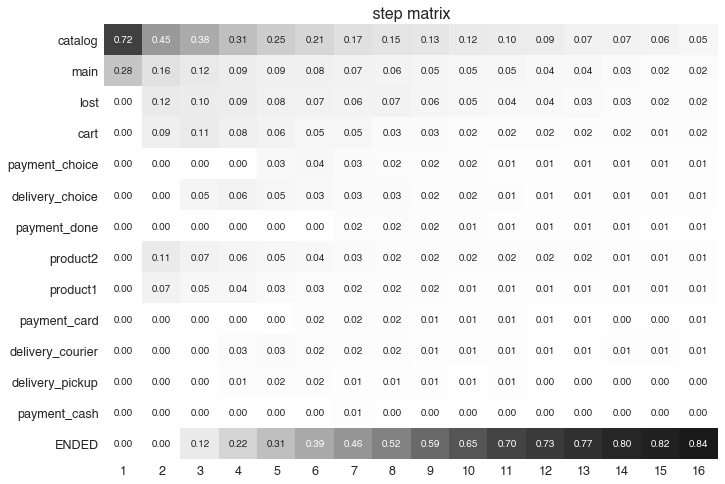

In [5]:
data.rete.step_matrix(max_steps=16);

# Thresholding

# Targets analysis

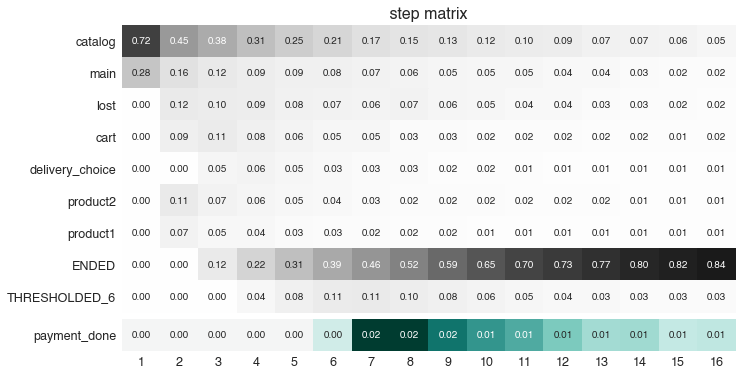

In [6]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['payment_done']);

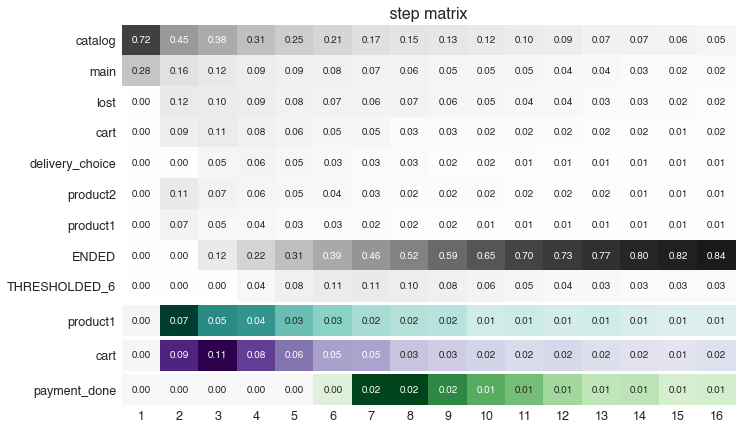

In [7]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1','cart','payment_done']);

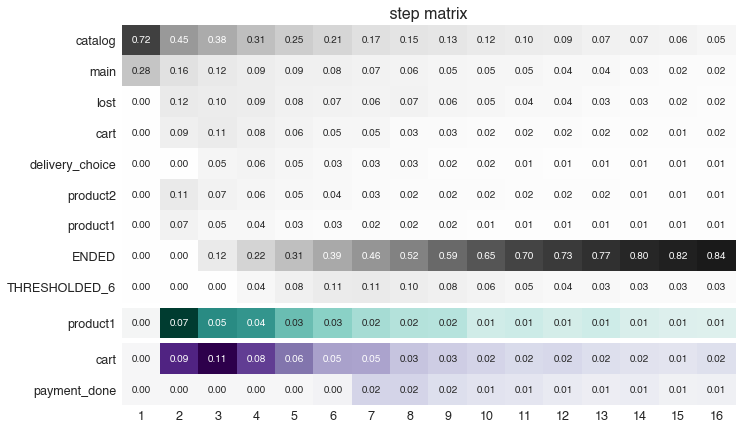

In [8]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']]);

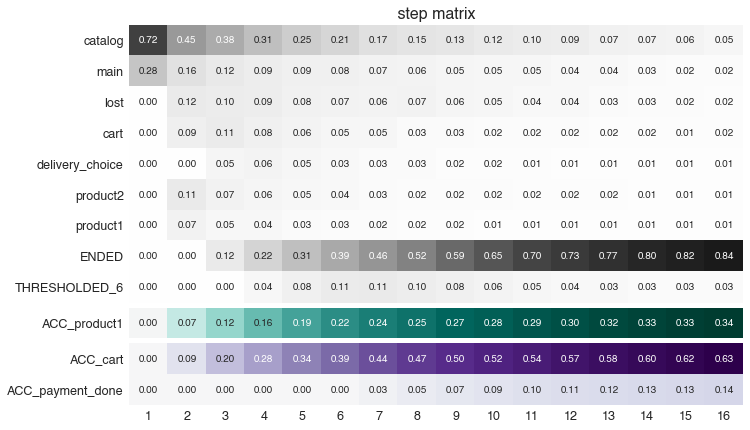

In [9]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='only');

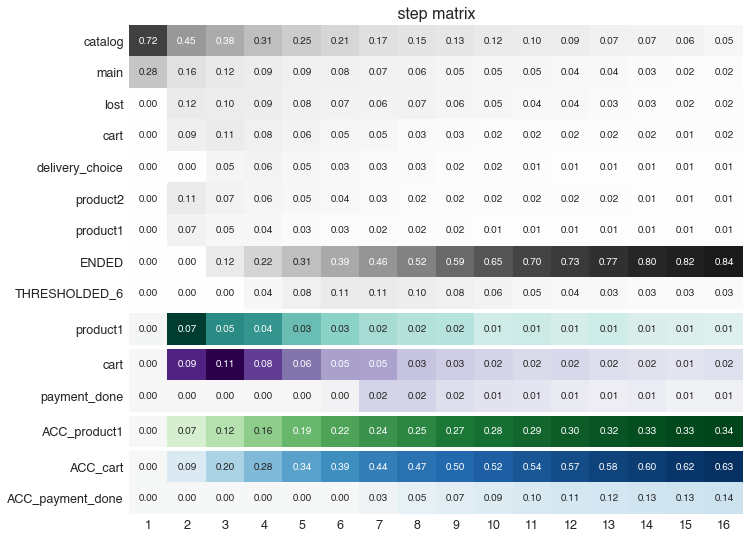

In [10]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='both');

# Centered step matrix

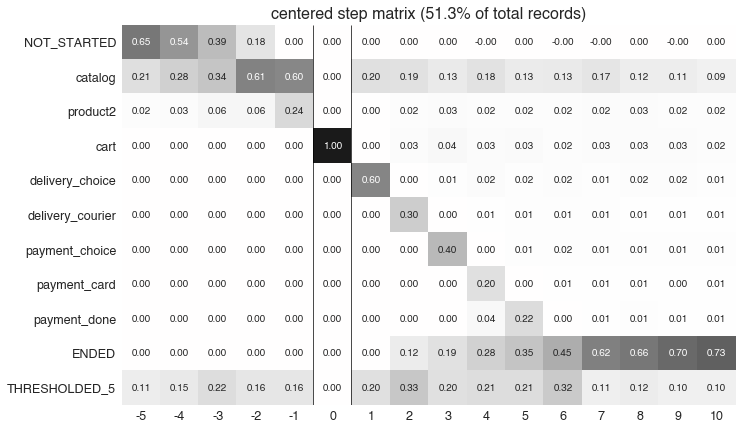

In [11]:
data.rete.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1});

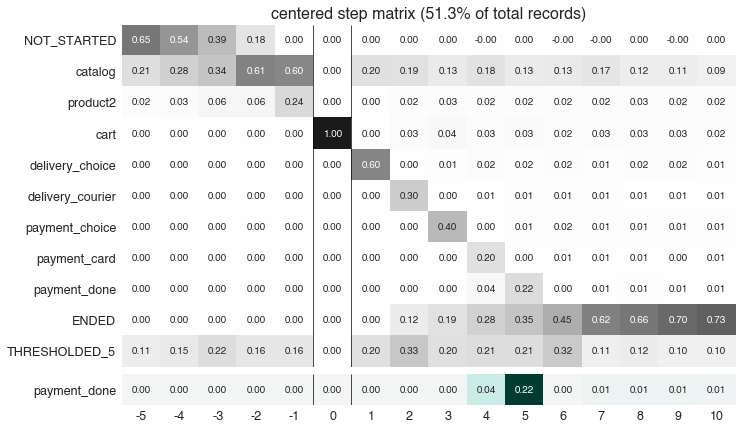

In [12]:
data.rete.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      targets=['payment_done']);

# Custom events sorting

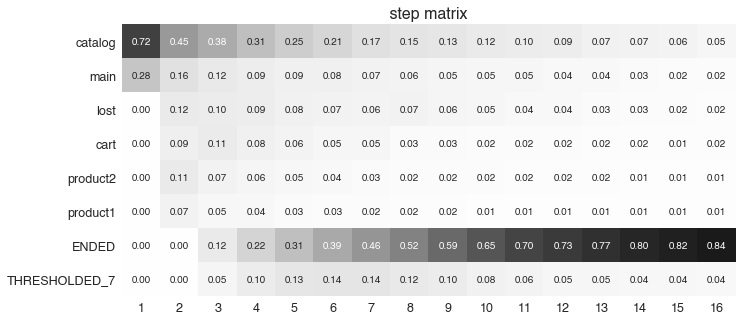

In [13]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.07);

In [14]:
print(retentioneering.config['step_matrix']['sorting'])

['catalog', 'main', 'lost', 'cart', 'product2', 'product1', 'ENDED', 'THRESHOLDED_7']


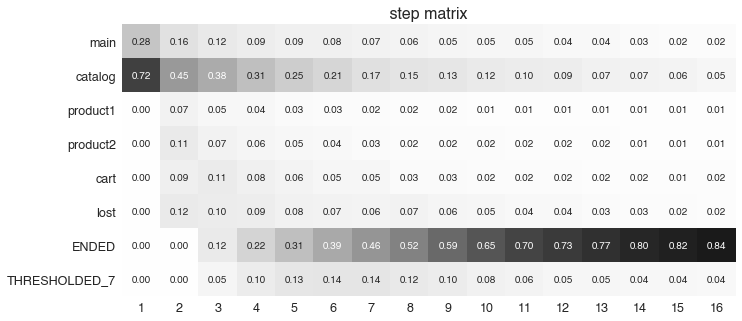

In [15]:
custom_order = ['main',
                'catalog', 
                'product1',                
                'product2',                
                'cart',
                'lost',                
                'ENDED',
                'THRESHOLDED_7']

data.rete.step_matrix(max_steps=16,
                      thresh=0.07,
                      sorting=custom_order);

# Differential step_matrix

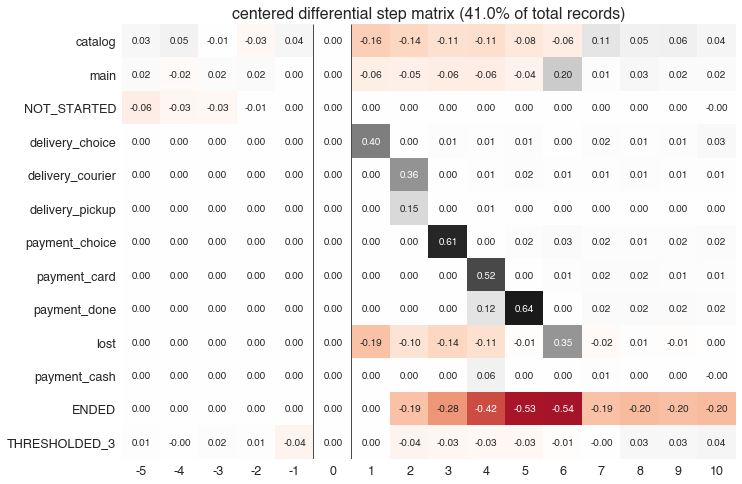

In [16]:
g1 = set(data[data['event']=='payment_done']['user_id'])
g2 = set(data['user_id']) - g1

data.rete.step_matrix(max_steps=16,
                      thresh = 0.05,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      groups=(g1, g2));

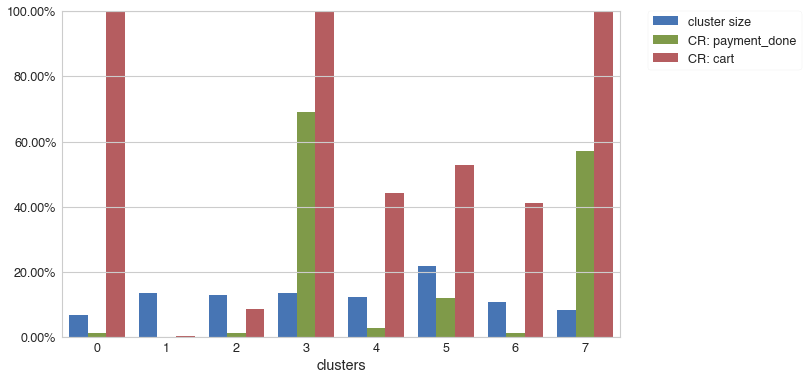

In [17]:
data.rete.get_clusters(plot_type='cluster_bar',
                       targets=['payment_done', 'cart'],
                       refit_cluster=True);

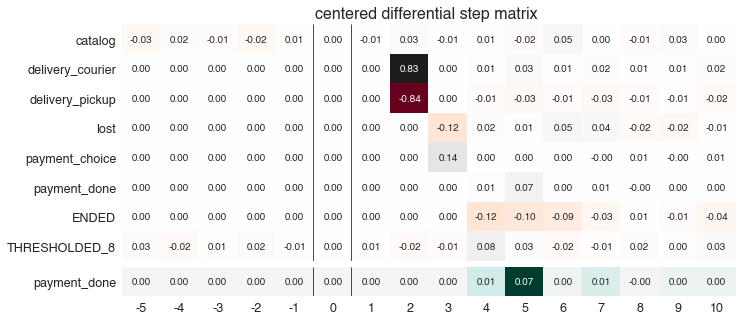

In [18]:
g1 = data.rete.cluster_mapping[3]
g2 = data.rete.cluster_mapping[7]

data.rete.step_matrix(max_steps=16,
                      thresh = 0.05,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      groups=(g1, g2),
                      targets = ['payment_done']);